# Skip-gram word2vec
In this notebook, I'll lead you through using TensorFlow to implement the word2vec algorithm using the skip-gram architecture. By implementing this, you'll learn about embedding words for use in natural language processing. This will come in handy when dealing with things like machine translation.

Word embeddings
When you're dealing with words in text, you end up with tens of thousands of classes to predict, one for each word. Trying to one-hot encode these words is massively inefficient, you'll have one element set to 1 and the other 50,000 set to 0. The matrix multiplication going into the first hidden layer will have almost all of the resulting values be zero. This a huge waste of computation.
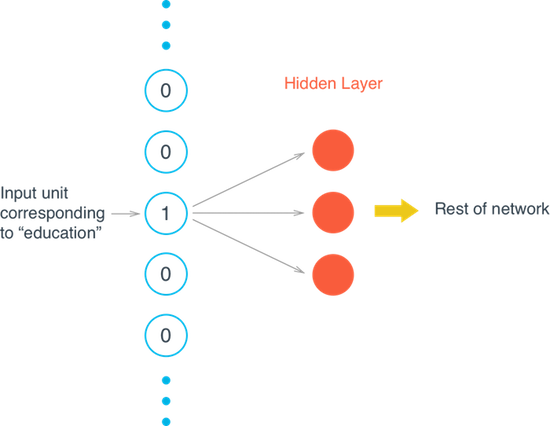

To solve this problem and greatly increase the efficiency of our networks, we use what are called embeddings. Embeddings are just a fully connected layer like you've seen before. We call this layer the embedding layer and the weights are embedding weights. We skip the multiplication into the embedding layer by instead directly grabbing the hidden layer values from the weight matrix. We can do this because the multiplication of a one-hot encoded vector with a matrix returns the row of the matrix corresponding the index of the "on" input unit.

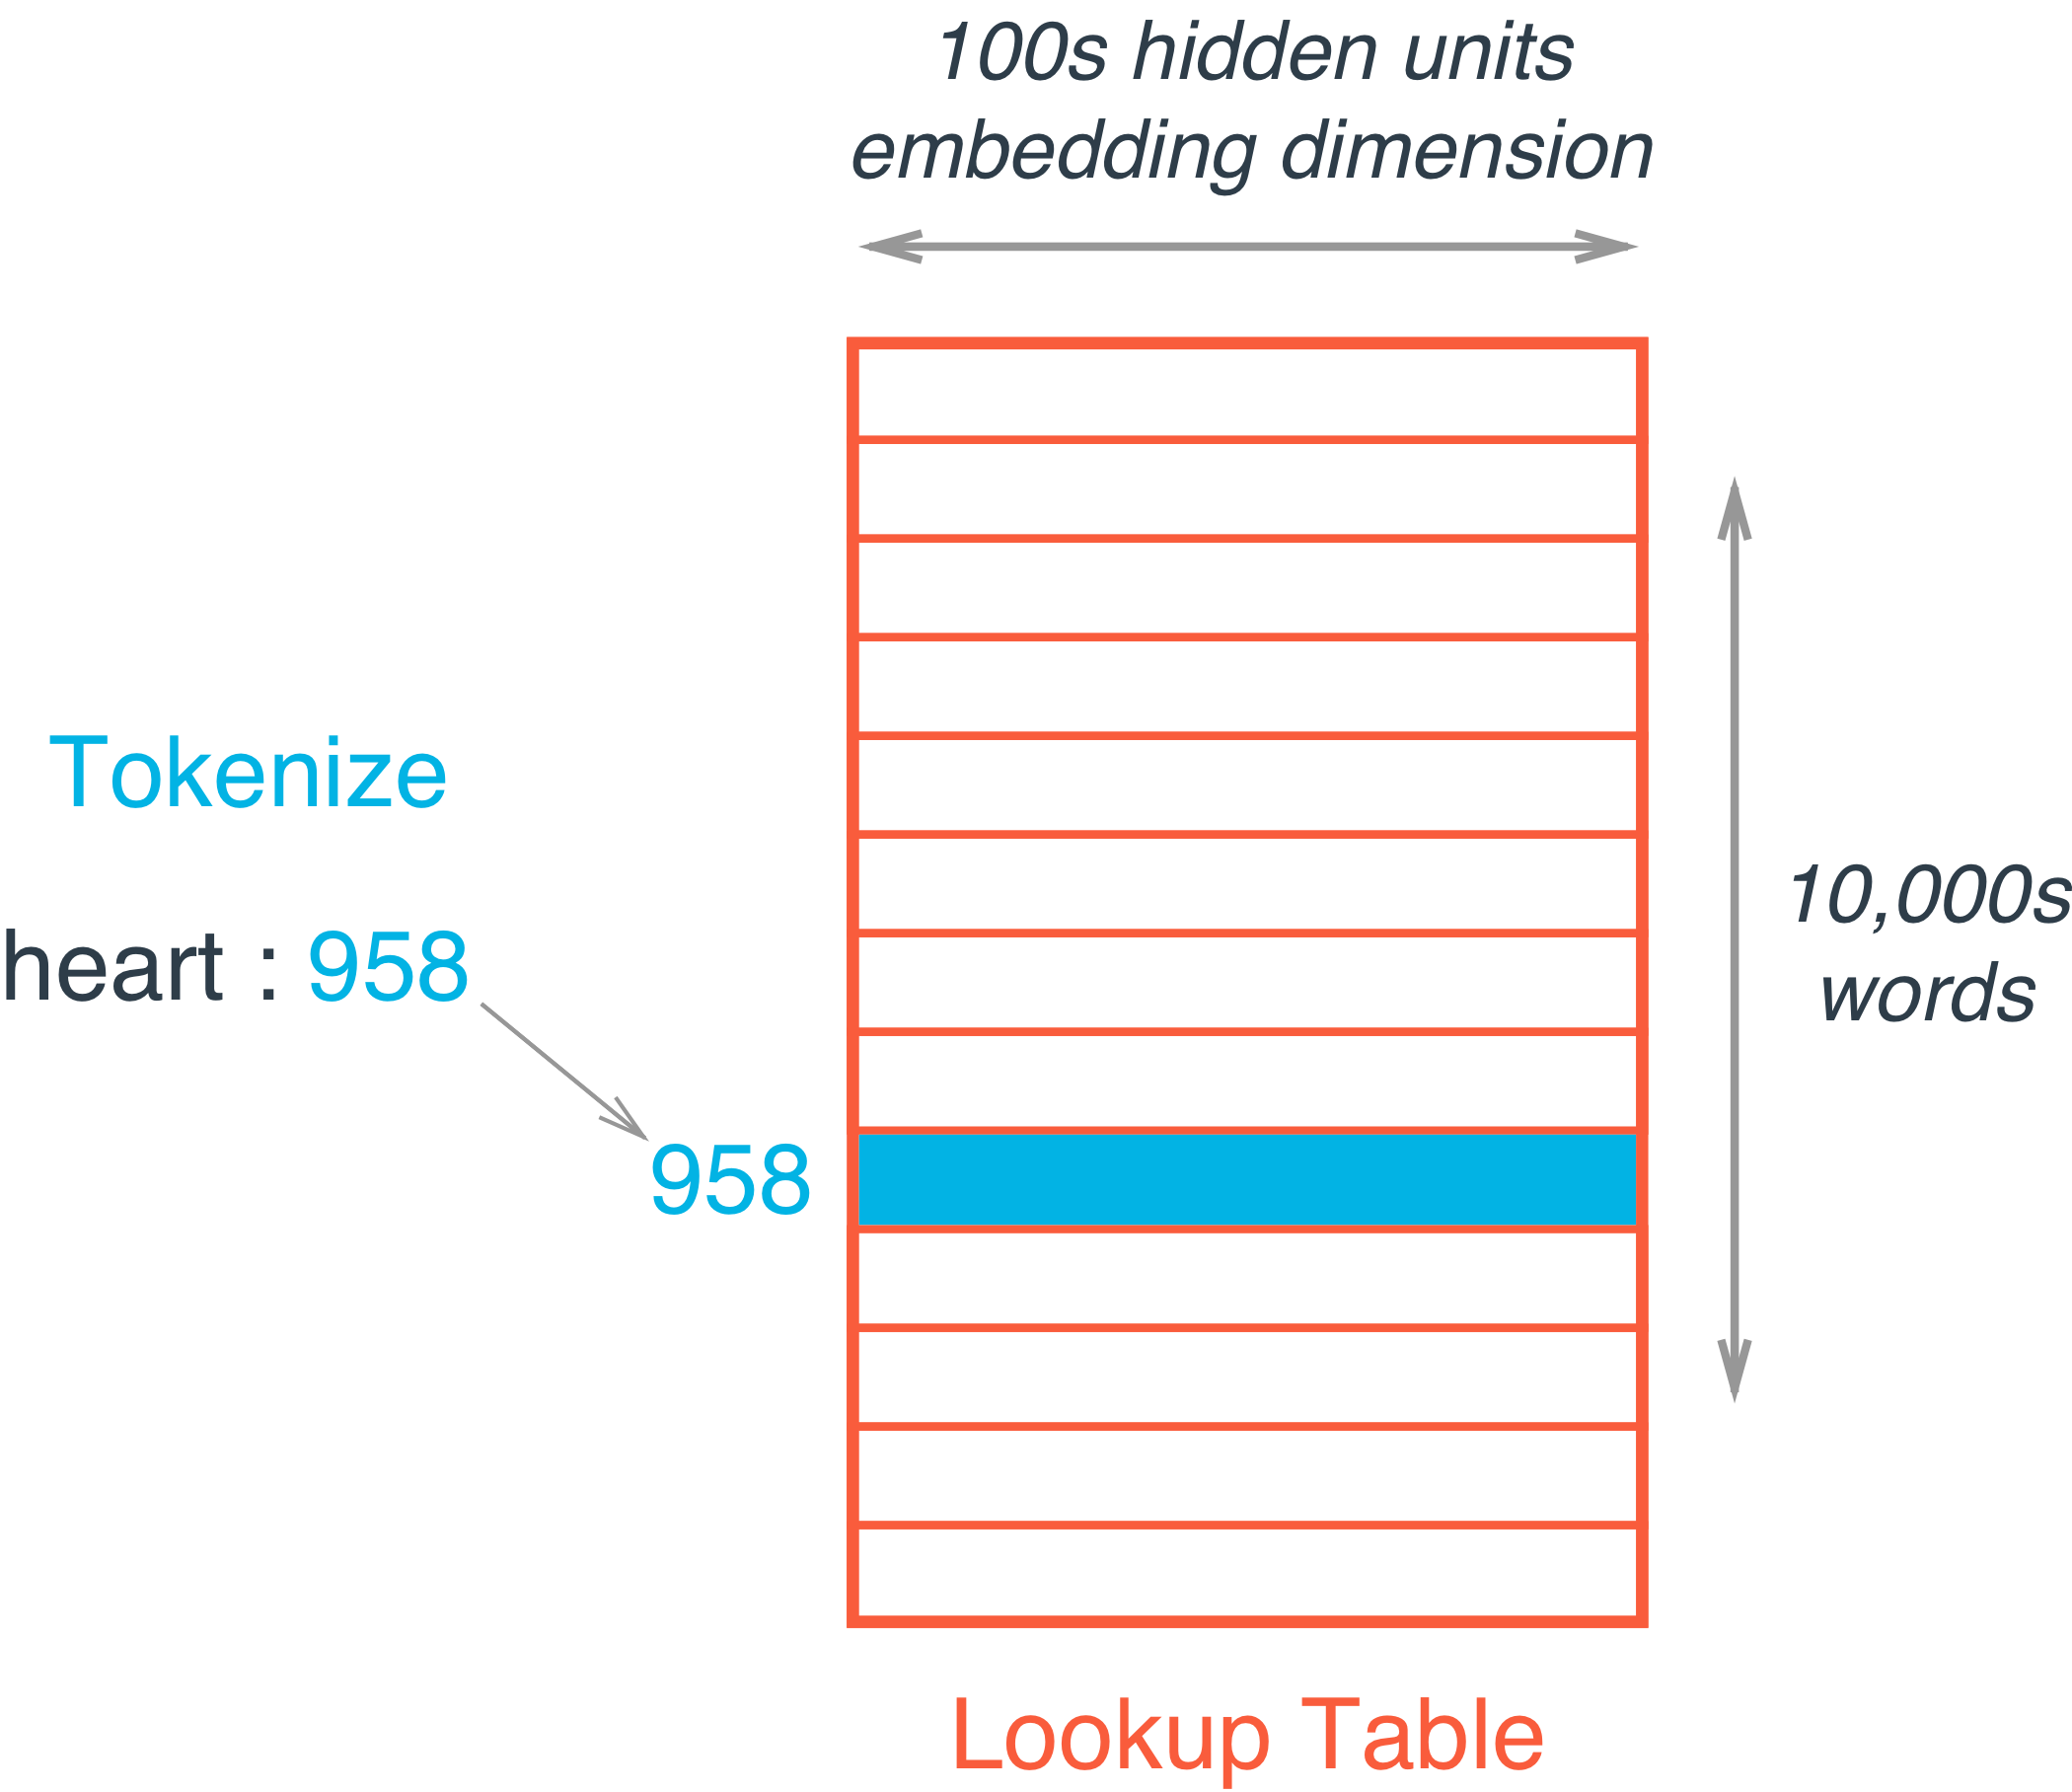

Instead of doing the matrix multiplication, we use the weight matrix as a lookup table. We encode the words as integers, for example "heart" is encoded as 958, "mind" as 18094. Then to get hidden layer values for "heart", you just take the 958th row of the embedding matrix. This process is called an embedding lookup and the number of hidden units is the embedding dimension.

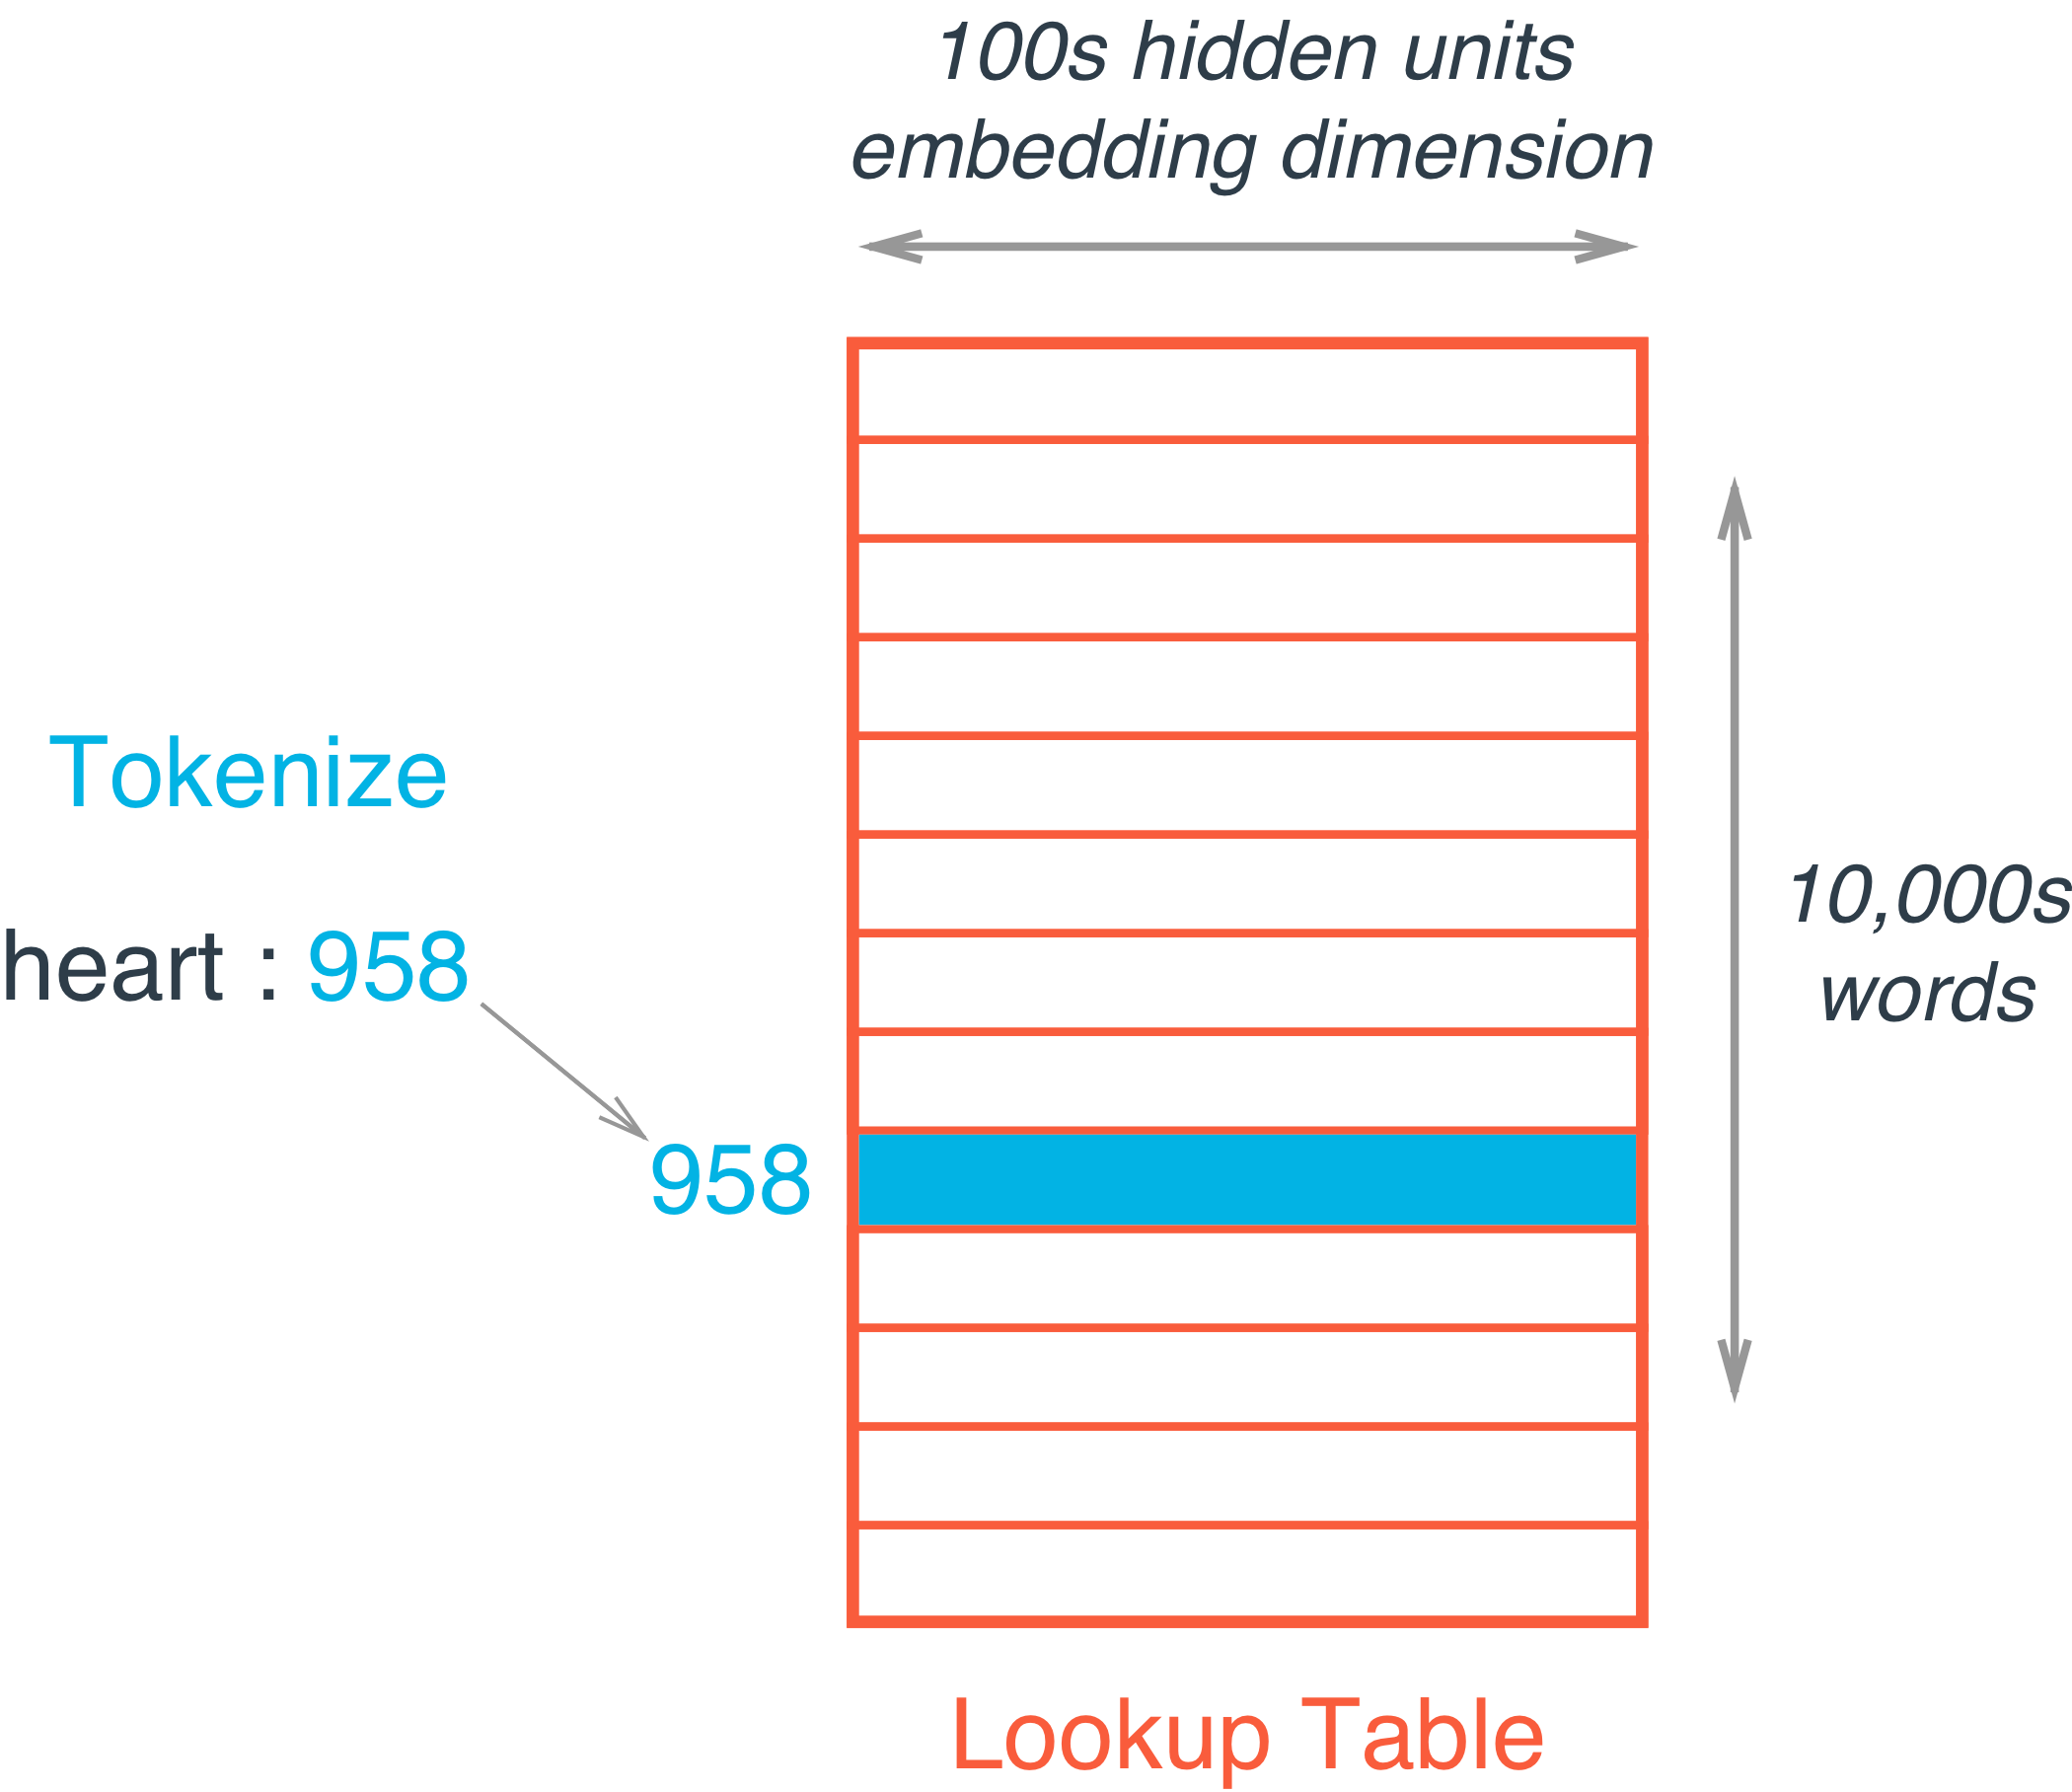

There is nothing magical going on here. The embedding lookup table is just a weight matrix. The embedding layer is just a hidden layer. The lookup is just a shortcut for the matrix multiplication. The lookup table is trained just like any weight matrix as well.

Embeddings aren't only used for words of course. You can use them for any model where you have a massive number of classes. A particular type of model called Word2Vec uses the embedding layer to find vector representations of words that contain semantic meaning.

#### Word2Vec
The word2vec algorithm finds much more efficient representations by finding vectors that represent the words. These vectors also contain semantic information about the words. Words that show up in similar contexts, such as "black", "white", and "red" will have vectors near each other. There are two architectures for implementing word2vec, CBOW (Continuous Bag-Of-Words) and Skip-gram.

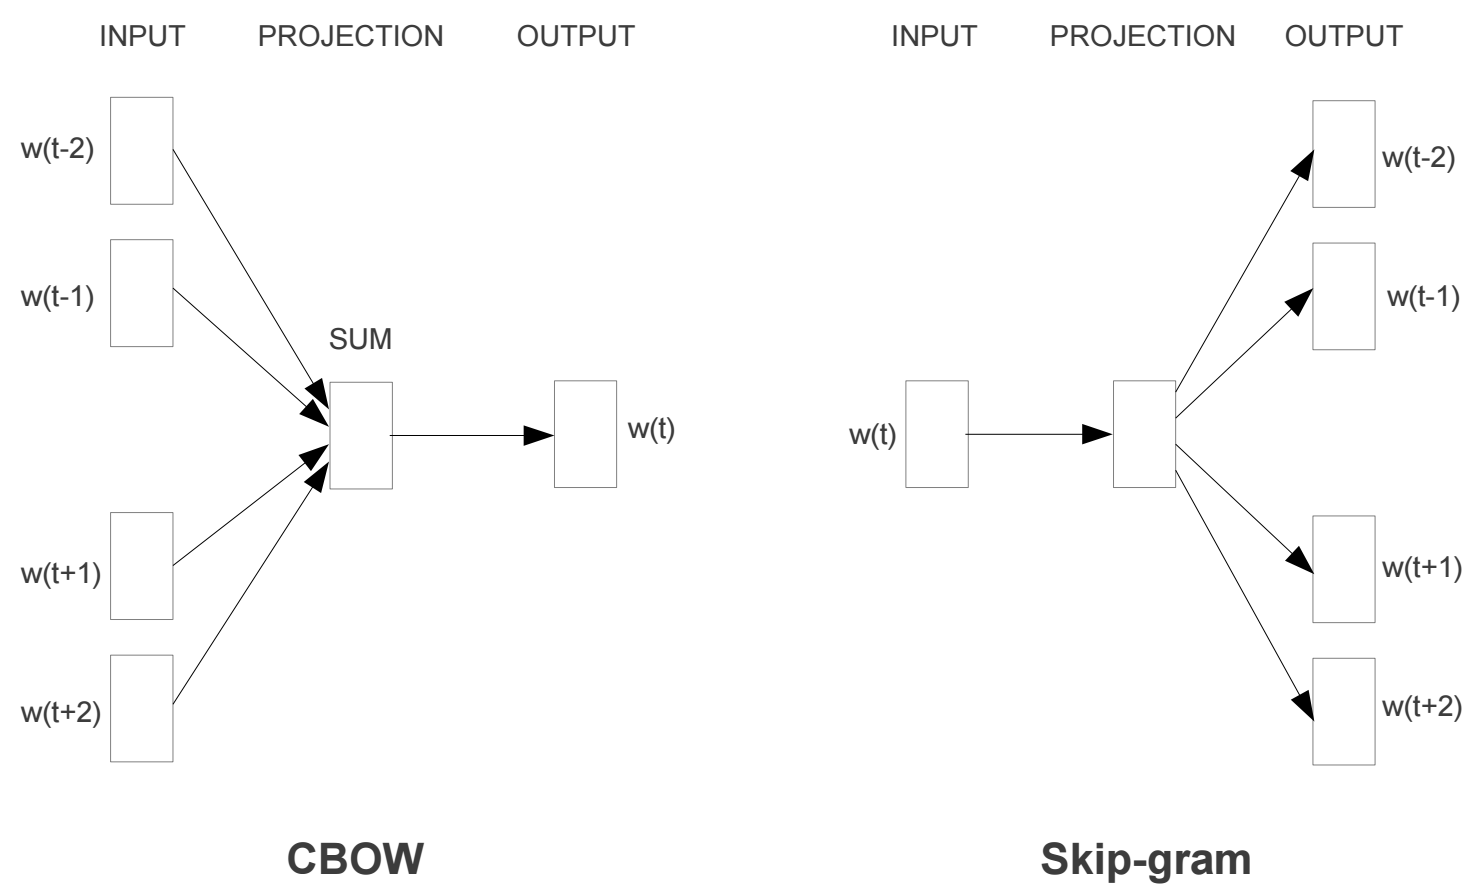

In this implementation, we'll be using the skip-gram architecture because it performs better than CBOW. Here, we pass in a word and try to predict the words surrounding it in the text. In this way, we can train the network to learn representations for words that show up in similar contexts.

First up, importing packages.

In [ ]:
import time

import numpy as np
import tensorflow as tf

import utils

Load the text8 dataset, a file of cleaned up Wikipedia articles from Matt Mahoney. The next cell will download the data set to the data folder. Then you can extract it and delete the archive file to save storage space.

In [ ]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

dataset_folder_path = 'data'
dataset_filename = 'text8.zip'
dataset_name = 'Text8 Dataset'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(dataset_filename):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc=dataset_name) as pbar:
        urlretrieve(
            'http://mattmahoney.net/dc/text8.zip',
            dataset_filename,
            pbar.hook)

if not isdir(dataset_folder_path):
    with zipfile.ZipFile(dataset_filename) as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        
with open('data/text8') as f:
    text = f.read()

#### Preprocessing

Here I'm fixing up the text to make training easier. This comes from the utils module I wrote. The preprocess function coverts any punctuation into tokens, so a period is changed to <PERIOD>. In this data set, there aren't any periods, but it will help in other NLP problems. I'm also removing all words that show up five or fewer times in the dataset. This will greatly reduce issues due to noise in the data and improve the quality of the vector representations. If you want to write your own functions for this stuff, go for it.

In [ ]:
words = utils.preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']

In [ ]:
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words: 16680599
Unique words: 63641

And here I'm creating dictionaries to covert words to integers and backwards, integers to words. The integers are assigned in descending frequency order, so the most frequent word ("the") is given the integer 0 and the next most frequent is 1 and so on. The words are converted to integers and stored in the list int_words.

In [ ]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

Subsampling
Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by

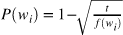

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

I'm going to leave this up to you as an exercise. This is more of a programming challenge, than about deep learning specifically. But, being able to prepare your data for your network is an important skill to have. Check out my solution to see how I did it.

##### Exercise: 
Implement subsampling for the words in int_words. That is, go through int_words and discard each word given the probablility $P(w_i)$ shown above. Note that $P(w_i)$ is the probability that a word is discarded. Assign the subsampled data to train_words.

In [ ]:
from collections import Counter
import random

threshold = 1e-5
word_counts = Counter(int_words)
total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

#### Making batches

Now that our data is in good shape, we need to get it into the proper form to pass it into our network. With the skip-gram architecture, for each word in the text, we want to grab all the words in a window around that word, with size $C$.

From Mikolov et al.:

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $&lt; 1; C &gt;$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

##### Exercise:
Implement a function get_target that receives a list of words, an index, and a window size, then returns a list of words in the window around the index. Make sure to use the algorithm described above, where you choose a random number of words from the window.

In [ ]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = set(words[start:idx] + words[idx+1:stop+1])
    
    return list(target_words)

Here's a function that returns batches for our network. The idea is that it grabs batch_size words from a words list. Then for each of those words, it gets the target words in the window. I haven't found a way to pass in a random number of target words and get it to work with the architecture, so I make one row per input-target pair. This is a generator function by the way, helps save memory.

In [ ]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y

### Building the Graph

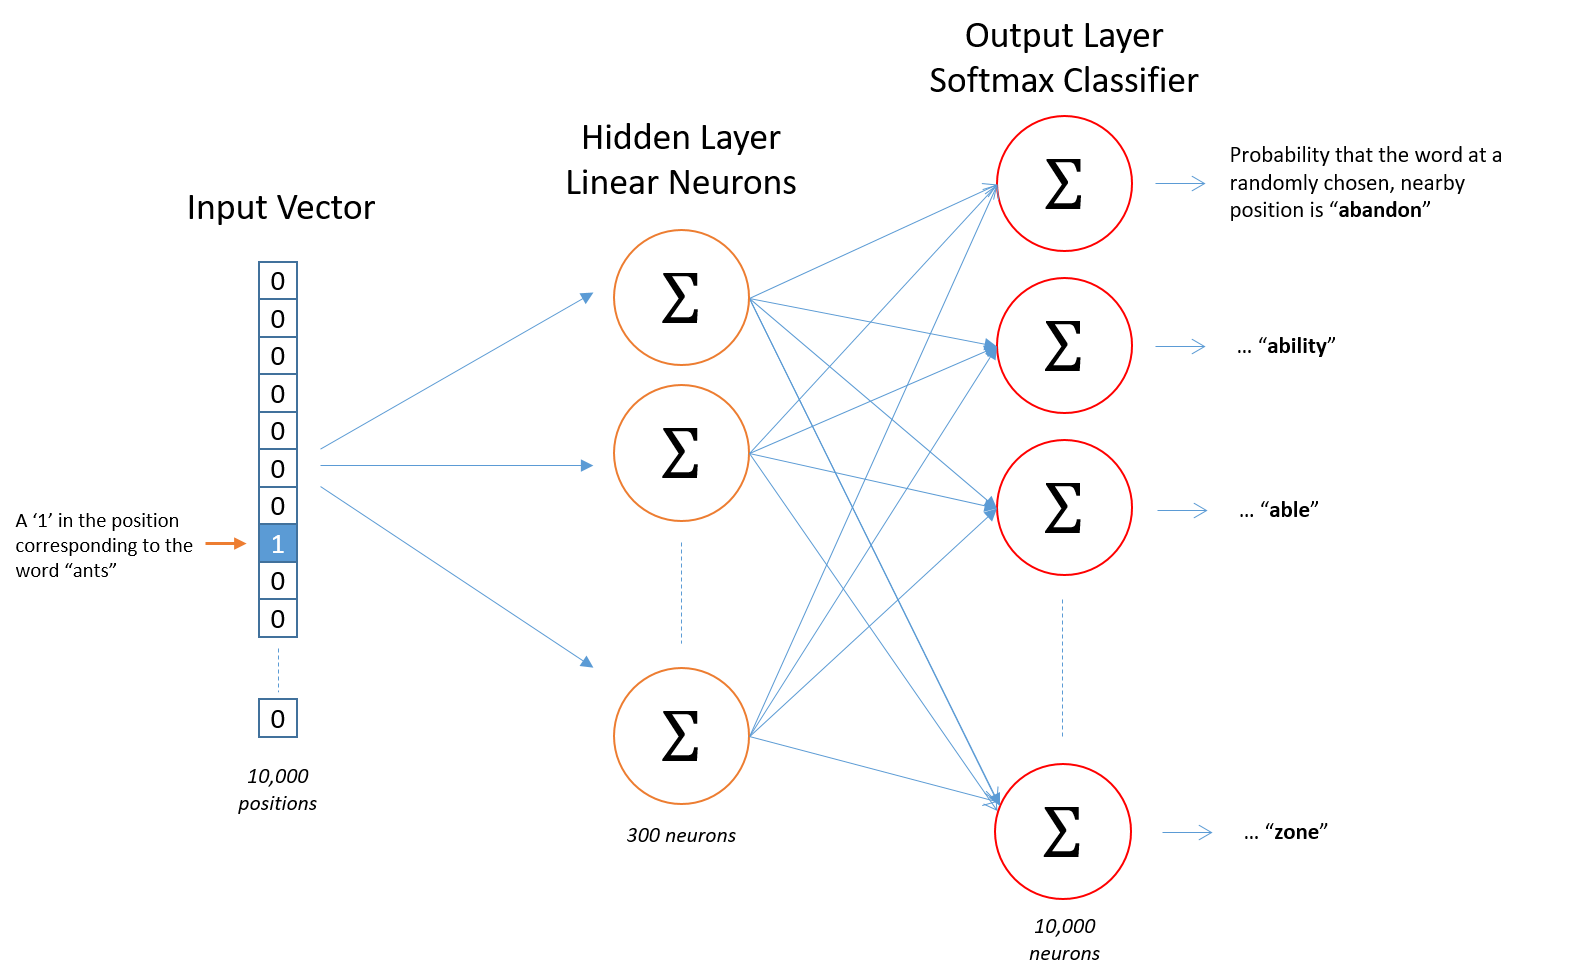

The input words are passed in as integers. This will go into a hidden layer of linear units, then into a softmax layer. We'll use the softmax layer to make a prediction like normal.

The idea here is to train the hidden layer weight matrix to find efficient representations for our words. We can discard the softmax layer becuase we don't really care about making predictions with this network. We just want the embedding matrix so we can use it in other networks we build from the dataset.

I'm going to have you build the graph in stages now. First off, creating the inputs and labels placeholders like normal.

##### Exercise:
Assign inputs and labels using tf.placeholder. We're going to be passing in integers, so set the data types to tf.int32. The batches we're passing in will have varying sizes, so set the batch sizes to [None]. To make things work later, you'll need to set the second dimension of labels to None or 1.

In [ ]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
#     labels = tf.placeholder(tf.int32, [None, None], name='labels')
    labels = tf.placeholder(tf.int32, [None, None], name='labels')

### Embedding

The embedding matrix has a size of the number of words by the number of units in the hidden layer. So, if you have 10,000 words and 300 hidden units, the matrix will have size $10,000 \times 300$. Remember that we're using tokenized data for our inputs, usually as integers, where the number of tokens is the number of words in our vocabulary.

##### Exercise: 
Tensorflow provides a convenient function tf.nn.embedding_lookup that does this lookup for us. You pass in the embedding matrix and a tensor of integers, then it returns rows in the matrix corresponding to those integers. Below, set the number of embedding features you'll use (200 is a good start), create the embedding matrix variable, and use tf.nn.embedding_lookup to get the embedding tensors. For the embedding matrix, I suggest you initialize it with a uniform random numbers between -1 and 1 using tf.random_uniform.

In [ ]:
n_vocab = len(int_to_vocab)
n_embedding =  300
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs) # use tf.nn.embedding_lookup to get the hidden layer outpu

### Negative sampling

For every example we give the network, we train it using the output from the softmax layer. That means for each input, we're making very small changes to millions of weights even though we only have one true example. This makes training the network very inefficient. We can approximate the loss from the softmax layer by only updating a small subset of all the weights at once. We'll update the weights for the correct label, but only a small number of incorrect labels. This is called "negative sampling". Tensorflow has a convenient function to do this, tf.nn.sampled_softmax_loss.

##### Exercise:
Below, create weights and biases for the softmax layer. Then, use tf.nn.sampled_softmax_loss to calculate the loss. Be sure to read the documentation to figure out how it works.

In [ ]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding))) # create softmax weight matrix here
    softmax_b = tf.Variable(tf.zeros(n_vocab), name="softmax_bias") # create softmax biases here
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(
        weights=softmax_w,
        biases=softmax_b,
        labels=labels,
        inputs=embed,
        num_sampled=n_sampled,
        num_classes=n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

### Validation
This code is from Thushan Ganegedara's implementation. Here we're going to choose a few common words and few uncommon words. Then, we'll print out the closest words to them. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

In [ ]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [ ]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

### Training
Below is the code to train the network. Every 100 batches it reports the training loss. Every 1000 batches, it'll print out the validation words.

In [ ]:
epochs = 10
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                ## From Thushan Ganegedara's implementation
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/10 Iteration: 100 Avg. Training loss: 21.6334 0.3228 sec/batch
Epoch 1/10 Iteration: 200 Avg. Training loss: 21.4442 0.3370 sec/batch
Epoch 1/10 Iteration: 300 Avg. Training loss: 21.1499 0.3516 sec/batch
Epoch 1/10 Iteration: 400 Avg. Training loss: 21.0702 0.3403 sec/batch
Epoch 1/10 Iteration: 500 Avg. Training loss: 20.9330 0.3313 sec/batch
Epoch 1/10 Iteration: 600 Avg. Training loss: 20.8610 0.3657 sec/batch
Epoch 1/10 Iteration: 700 Avg. Training loss: 20.7380 0.3273 sec/batch
Epoch 1/10 Iteration: 800 Avg. Training loss: 20.4748 0.3289 sec/batch
Epoch 1/10 Iteration: 900 Avg. Training loss: 20.3871 0.3252 sec/batch
Epoch 1/10 Iteration: 1000 Avg. Training loss: 20.2497 0.3261 sec/batch
Nearest to all: basalt, synoptics, messalina, frobisher, serviced, lipoproteins, hillery, fields,
Nearest to no: abuse, agile, fibre, quixtar, irascible, idolatrous, beak, heist,
Nearest to six: homered, manuscript, hanrahan, radii, raum, cassidy, warlords, carmine,
Nearest to would: detours, watershed, connotations, syllables, berated, redesign, slipping, acm,
Nearest to these: ceramic, rose, ouverture, cyprinus, mechanics, spacey, raab, eclecticism,
Nearest to also: pleading, nightingale, sax, voxel, shogunate, drawbacks, acrylamide, what,
Nearest to have: consistency, unemployed, qualify, baltasar, enciphered, playlists, clara, tentacle,
Nearest to other: westland, harring, hymnist, vojvodina, mba, jarring, berra, carnap,
Nearest to marriage: stitch, territories, rubidium, eugenicists, winkler, ephraim, suffixed, servicing,
Nearest to freedom: balances, kfor, masaryk, amontillado, praetors, cosimo, ramzi, pillaged,
Nearest to powers: boathouse, games, singing, rumour, franjo, dpp, dol, rugrats,
Nearest to nobel: nationally, sinha, aerosols, arose, beans, szombathely, reuven, recharged,
Nearest to running: almenr, quintilis, illustrators, employs, stressing, waddell, ila, py,
Nearest to accepted: christoph, waylon, gegenschein, calibrate, handgun, wallachia, mural, subfamily,
Nearest to event: athlon, aleph, keyboard, maintainer, azhar, tsk, sistani, shrugged,
Nearest to test: melancholy, socialiste, flukes, spectroscopy, scenarios, ucsb, sissy, haredi,
Epoch 1/10 Iteration: 1100 Avg. Training loss: 20.1844 0.3370 sec/batch
Epoch 1/10 Iteration: 1200 Avg. Training loss: 20.0259 0.3340 sec/batch
Epoch 1/10 Iteration: 1300 Avg. Training loss: 19.8430 0.3268 sec/batch
Epoch 1/10 Iteration: 1400 Avg. Training loss: 19.8202 0.3242 sec/batch
Epoch 1/10 Iteration: 1500 Avg. Training loss: 19.6500 0.3244 sec/batch
Epoch 1/10 Iteration: 1600 Avg. Training loss: 19.6433 0.3265 sec/batch
Epoch 1/10 Iteration: 1700 Avg. Training loss: 19.4077 0.3246 sec/batch
Epoch 1/10 Iteration: 1800 Avg. Training loss: 19.3400 0.3213 sec/batch
Epoch 1/10 Iteration: 1900 Avg. Training loss: 19.2622 0.3239 sec/batch
Epoch 1/10 Iteration: 2000 Avg. Training loss: 19.1260 0.3277 sec/batch
Nearest to all: basalt, frobisher, synoptics, messalina, dissenter, fields, serviced, tientsin,
Nearest to no: abuse, agile, irascible, fibre, quixtar, heist, neapolitan, tr,
Nearest to six: homered, manuscript, radii, cassidy, hanrahan, raum, carmine, warlords,
Nearest to would: detours, watershed, redesign, connotations, syllables, therese, berated, directors,
Nearest to these: ceramic, rose, ouverture, cyprinus, raab, spacey, mechanics, lastly,
Nearest to also: pleading, nightingale, voxel, sax, sibelius, shogunate, what, acrylamide,
Nearest to have: consistency, qualify, unemployed, baltasar, enciphered, clara, tentacle, playlists,
Nearest to other: harring, vojvodina, westland, hymnist, mba, seriousness, berra, jarring,
Nearest to marriage: stitch, eugenicists, rubidium, ephraim, territories, winkler, dolby, topos,
Nearest to freedom: balances, kfor, glise, praetors, masaryk, nob, amontillado, lamp,
Nearest to powers: boathouse, games, singing, rumour, franjo, rugrats, photographers, dpp,
Nearest to nobel: nationally, aerosols, sinha, photographs, arose, beans, chip, szombathely,
Nearest to running: almenr, quintilis, employs, illustrators, stressing, py, waddell, orly,
Nearest to accepted: christoph, waylon, gegenschein, handgun, calibrate, subfamily, mural, harper,
Nearest to event: athlon, aleph, maintainer, keyboard, tsk, shrugged, sistani, speeding,
Nearest to test: melancholy, socialiste, flukes, spectroscopy, scenarios, heel, ucsb, haredi,
Epoch 1/10 Iteration: 2100 Avg. Training loss: 18.9407 0.3342 sec/batch
Epoch 1/10 Iteration: 2200 Avg. Training loss: 18.8736 0.3259 sec/batch
Epoch 1/10 Iteration: 2300 Avg. Training loss: 18.7959 0.3294 sec/batch
Epoch 1/10 Iteration: 2400 Avg. Training loss: 18.6379 0.3293 sec/batch
Epoch 1/10 Iteration: 2500 Avg. Training loss: 18.5312 0.3220 sec/batch
Epoch 1/10 Iteration: 2600 Avg. Training loss: 18.4229 0.3270 sec/batch
Epoch 1/10 Iteration: 2700 Avg. Training loss: 18.2750 0.3218 sec/batch
Epoch 1/10 Iteration: 2800 Avg. Training loss: 18.2437 0.3183 sec/batch
Epoch 1/10 Iteration: 2900 Avg. Training loss: 18.1186 0.3181 sec/batch
Epoch 1/10 Iteration: 3000 Avg. Training loss: 18.1488 0.3225 sec/batch
Nearest to all: frobisher, messalina, dissenter, basalt, lipoproteins, tientsin, symbolical, fields,
Nearest to no: abuse, agile, heist, fibre, irascible, quixtar, quality, neapolitan,
Nearest to six: manuscript, homered, hanrahan, radii, cassidy, raum, carmine, backing,
Nearest to would: detours, watershed, berated, redesign, connotations, directors, xylem, satisfiability,
Nearest to these: ceramic, rose, ouverture, cyprinus, raab, lastly, mechanics, spacey,
Nearest to also: pleading, nightingale, sax, what, sibelius, voxel, shogunate, fishkeeping,
Nearest to have: qualify, consistency, tentacle, unemployed, clara, baltasar, strategists, enciphered,
Nearest to other: vojvodina, hymnist, westland, mba, harring, berra, carnap, jarring,
Nearest to marriage: stitch, rubidium, eugenicists, ephraim, dolby, topos, fenwick, exponentials,
Nearest to freedom: balances, glise, kfor, lamp, praetors, skirmishes, ramzi, nob,
Nearest to powers: boathouse, rumour, games, singing, franjo, photographers, rugrats, synoptic,
Nearest to nobel: nationally, sinha, aerosols, arose, photographs, beans, chip, recharged,
Nearest to running: almenr, quintilis, illustrators, employs, stressing, py, waddell, ila,
Nearest to accepted: gegenschein, waylon, christoph, handgun, calibrate, mural, subfamily, televisions,
Nearest to event: athlon, keyboard, aleph, maintainer, brushing, tsk, sistani, speeding,
Nearest to test: melancholy, spectroscopy, flukes, socialiste, universelle, haredi, scenarios, ucsb,
Epoch 1/10 Iteration: 3100 Avg. Training loss: 17.9677 0.3190 sec/batch
Epoch 1/10 Iteration: 3200 Avg. Training loss: 17.8299 0.3199 sec/batch
Epoch 1/10 Iteration: 3300 Avg. Training loss: 17.7507 0.3127 sec/batch
Epoch 1/10 Iteration: 3400 Avg. Training loss: 17.6321 0.3102 sec/batch
Epoch 1/10 Iteration: 3500 Avg. Training loss: 17.4914 0.3173 sec/batch
Epoch 1/10 Iteration: 3600 Avg. Training loss: 17.5103 0.3164 sec/batch
Epoch 1/10 Iteration: 3700 Avg. Training loss: 17.2889 0.3161 sec/batch
Epoch 1/10 Iteration: 3800 Avg. Training loss: 17.2722 0.3140 sec/batch
Epoch 1/10 Iteration: 3900 Avg. Training loss: 17.1012 0.3175 sec/batch
Epoch 1/10 Iteration: 4000 Avg. Training loss: 17.0454 0.3162 sec/batch
Nearest to all: messalina, frobisher, dissenter, lipoproteins, limburgish, tientsin, basalt, banquets,
Nearest to no: agile, abuse, heist, quixtar, neapolitan, irascible, tr, comme,
Nearest to six: manuscript, cassidy, raum, homered, radii, carmine, hanrahan, strategos,
Nearest to would: detours, watershed, ermengarde, berated, redesign, connotations, bubbles, xylem,
Nearest to these: ceramic, rose, ouverture, raab, lastly, cyprinus, mechanics, spacey,
Nearest to also: pleading, nightingale, what, sax, voxel, fishkeeping, sibelius, philoctetes,
Nearest to have: qualify, consistency, tentacle, unemployed, clara, strategists, playlists, baltasar,
Nearest to other: vojvodina, harring, hymnist, mba, westland, jarring, arithmetics, berra,
Nearest to marriage: stitch, rubidium, exponentials, ephraim, eugenicists, topos, ledge, fenwick,
Nearest to freedom: balances, glise, skirmishes, kfor, lamp, invokes, pillaged, indoor,
Nearest to powers: boathouse, singing, games, franjo, synoptic, photographers, rumour, endomorphism,
Nearest to nobel: nationally, aerosols, photographs, sinha, beans, szombathely, arose, freud,
Nearest to running: almenr, illustrators, employs, quintilis, stressing, py, zeus, waddell,
Nearest to accepted: gegenschein, waylon, handgun, christoph, calibrate, mural, dmitri, subfamily,
Nearest to event: athlon, keyboard, aleph, brushing, tsk, blaxploitation, sistani, maintainer,
Nearest to test: melancholy, spectroscopy, flukes, socialiste, ucsb, scenarios, universelle, heel,
Epoch 1/10 Iteration: 4100 Avg. Training loss: 17.0536 0.3127 sec/batch
Epoch 1/10 Iteration: 4200 Avg. Training loss: 16.9083 0.3118 sec/batch
Epoch 1/10 Iteration: 4300 Avg. Training loss: 16.6818 0.3155 sec/batch
Epoch 1/10 Iteration: 4400 Avg. Training loss: 16.6697 0.3479 sec/batch
Epoch 1/10 Iteration: 4500 Avg. Training loss: 16.6074 0.3318 sec/batch
Epoch 1/10 Iteration: 4600 Avg. Training loss: 16.5353 0.3108 sec/batch
Epoch 2/10 Iteration: 4700 Avg. Training loss: 16.3890 0.2479 sec/batch
Epoch 2/10 Iteration: 4800 Avg. Training loss: 16.2499 0.3213 sec/batch
Epoch 2/10 Iteration: 4900 Avg. Training loss: 16.0729 0.3220 sec/batch
Epoch 2/10 Iteration: 5000 Avg. Training loss: 15.9826 0.3081 sec/batch
Nearest to all: lipoproteins, messalina, limburgish, frobisher, dissenter, symbolical, putrajaya, mn,
Nearest to no: heist, abuse, agile, tr, quixtar, oman, neapolitan, comme,
Nearest to six: radii, cassidy, hanrahan, homered, raum, manuscript, carmine, manon,
Nearest to would: detours, watershed, redesign, environments, ermengarde, bubbles, berated, ascalon,
Nearest to these: ceramic, ouverture, rose, raab, lastly, mechanics, cyprinus, spacey,
Nearest to also: what, pleading, sax, nightingale, sibelius, isaf, voxel, disc,
Nearest to have: consistency, tentacle, qualify, ferrari, kislev, playlists, unemployed, baltasar,
Nearest to other: vojvodina, mba, westland, hymnist, arithmetics, partnering, intercepting, porky,
Nearest to marriage: stitch, rubidium, eugenicists, exponentials, ephraim, topos, ledge, fenwick,
Nearest to freedom: balances, skirmishes, glise, height, indoor, kindergartens, nob, kfor,
Nearest to powers: boathouse, singing, franjo, games, endomorphism, synoptic, photographers, dpp,
Nearest to nobel: nationally, aerosols, photographs, sinha, arose, szombathely, cbs, reuven,
Nearest to running: almenr, quintilis, illustrators, stressing, employs, py, zeus, ila,
Nearest to accepted: gegenschein, waylon, handgun, calibrate, mural, christoph, dmitri, subfamily,
Nearest to event: athlon, keyboard, aleph, brushing, derided, tsk, speeding, blaxploitation,
Nearest to test: melancholy, flukes, spectroscopy, scenarios, socialiste, ucsb, mark, haredi,
Epoch 2/10 Iteration: 5100 Avg. Training loss: 16.0054 0.3069 sec/batch
Epoch 2/10 Iteration: 5200 Avg. Training loss: 15.8905 0.3422 sec/batch
Epoch 2/10 Iteration: 5300 Avg. Training loss: 15.6804 0.3277 sec/batch
Epoch 2/10 Iteration: 5400 Avg. Training loss: 15.6524 0.3316 sec/batch
Epoch 2/10 Iteration: 5500 Avg. Training loss: 15.5441 0.3117 sec/batch
Epoch 2/10 Iteration: 5600 Avg. Training loss: 15.4958 0.3098 sec/batch
Epoch 2/10 Iteration: 5700 Avg. Training loss: 15.4035 0.3232 sec/batch
Epoch 2/10 Iteration: 5800 Avg. Training loss: 15.2437 0.3347 sec/batch
Epoch 2/10 Iteration: 5900 Avg. Training loss: 15.1693 0.3280 sec/batch
Epoch 2/10 Iteration: 6000 Avg. Training loss: 15.1121 0.3318 sec/batch
Nearest to all: lipoproteins, banquets, frobisher, messalina, iib, limburgish, socialite, symbolical,
Nearest to no: abuse, heist, tr, agile, comme, quality, oman, irascible,
Nearest to six: carmine, raum, radii, homered, manuscript, cassidy, manon, hanrahan,
Nearest to would: environments, watershed, detours, ermengarde, redesign, berated, brutally, connotations,
Nearest to these: ceramic, raab, from, mechanics, ouverture, lastly, rose, costner,
Nearest to also: what, sibelius, pleading, sax, nightingale, fishkeeping, cass, voxel,
Nearest to have: tentacle, consistency, americana, ferrari, kislev, playlists, enciphered, qualify,
Nearest to other: vojvodina, westland, partnering, mba, arithmetics, profiled, picton, carnap,
Nearest to marriage: rubidium, stitch, exponentials, eugenicists, ephraim, dolby, topos, specifically,
Nearest to freedom: glise, skirmishes, balances, kfor, cosimo, lamp, indoor, masaryk,
Nearest to powers: boathouse, singing, franjo, synoptic, games, berries, dpp, photographers,
Nearest to nobel: nationally, aerosols, photographs, sinha, reuven, szombathely, chip, arose,
Nearest to running: almenr, quintilis, illustrators, stressing, employs, py, zeus, ila,
Nearest to accepted: gegenschein, waylon, handgun, calibrate, christoph, mural, dmitri, harnesses,
Nearest to event: athlon, keyboard, brushing, aleph, speeding, blaxploitation, harappa, krebs,
Nearest to test: melancholy, flukes, scenarios, socialiste, spectroscopy, exhort, mark, haredi,
Epoch 2/10 Iteration: 6100 Avg. Training loss: 15.1063 0.3308 sec/batch
Epoch 2/10 Iteration: 6200 Avg. Training loss: 14.9993 0.3105 sec/batch
Epoch 2/10 Iteration: 6300 Avg. Training loss: 14.8877 0.3079 sec/batch
Epoch 2/10 Iteration: 6400 Avg. Training loss: 14.8350 0.3099 sec/batch
Epoch 2/10 Iteration: 6500 Avg. Training loss: 14.7696 0.3186 sec/batch
Epoch 2/10 Iteration: 6600 Avg. Training loss: 14.6486 0.3185 sec/batch
Epoch 2/10 Iteration: 6700 Avg. Training loss: 14.4448 0.3191 sec/batch
Epoch 2/10 Iteration: 6800 Avg. Training loss: 14.4515 0.3169 sec/batch
Epoch 2/10 Iteration: 6900 Avg. Training loss: 14.4692 0.3132 sec/batch
Epoch 2/10 Iteration: 7000 Avg. Training loss: 14.3954 0.3177 sec/batch
Nearest to all: it, well, frobisher, putrajaya, lipoproteins, banquets, legend, iib,
Nearest to no: heist, tr, comme, agile, quality, abuse, neapolitan, subrack,
Nearest to six: zero, carmine, on, radii, ln, manon, and, raum,
Nearest to would: often, detours, environments, watershed, connotations, euphoric, redesign, gab,
Nearest to these: from, in, of, the, to, ceramic, and, a,
Nearest to also: the, and, of, in, what, a, fishkeeping, to,
Nearest to have: in, of, a, the, be, three, that, infamous,
Nearest to other: vojvodina, codas, partnering, westland, arithmetics, manga, berio, porky,
Nearest to marriage: eugenicists, rubidium, exponentials, fenwick, specifically, stitch, topos, ephraim,
Nearest to freedom: balances, glise, skirmishes, kfor, masaryk, indoor, pillaged, height,
Nearest to powers: boathouse, singing, franjo, berries, synoptic, games, rumour, stardom,
Nearest to nobel: nationally, aerosols, photographs, sinha, freud, arose, szombathely, chip,
Nearest to running: almenr, illustrators, quintilis, employs, py, stressing, zeus, patrilineal,
Nearest to accepted: gegenschein, waylon, handgun, calibrate, christoph, mural, perches, puerta,
Nearest to event: athlon, keyboard, aleph, brushing, speeding, pattie, oakland, harappa,
Nearest to test: melancholy, flukes, socialiste, beachhead, scenarios, ucsb, exhort, spectroscopy,
Epoch 2/10 Iteration: 7100 Avg. Training loss: 14.4663 0.3185 sec/batch
Epoch 2/10 Iteration: 7200 Avg. Training loss: 14.1989 0.3157 sec/batch
Epoch 2/10 Iteration: 7300 Avg. Training loss: 14.0066 0.3109 sec/batch
Epoch 2/10 Iteration: 7400 Avg. Training loss: 14.0952 0.3119 sec/batch
Epoch 2/10 Iteration: 7500 Avg. Training loss: 14.0254 0.3225 sec/batch
Epoch 2/10 Iteration: 7600 Avg. Training loss: 13.8466 0.3346 sec/batch
Epoch 2/10 Iteration: 7700 Avg. Training loss: 13.7445 0.3399 sec/batch
Epoch 2/10 Iteration: 7800 Avg. Training loss: 13.8172 0.3380 sec/batch
Epoch 2/10 Iteration: 7900 Avg. Training loss: 13.5737 0.3362 sec/batch

Restore the trained network if you need to:

In [ ]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

### Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out this post from Christopher Olah to learn more about T-SNE and other ways to visualize high-dimensional data.

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [ ]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

In [ ]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

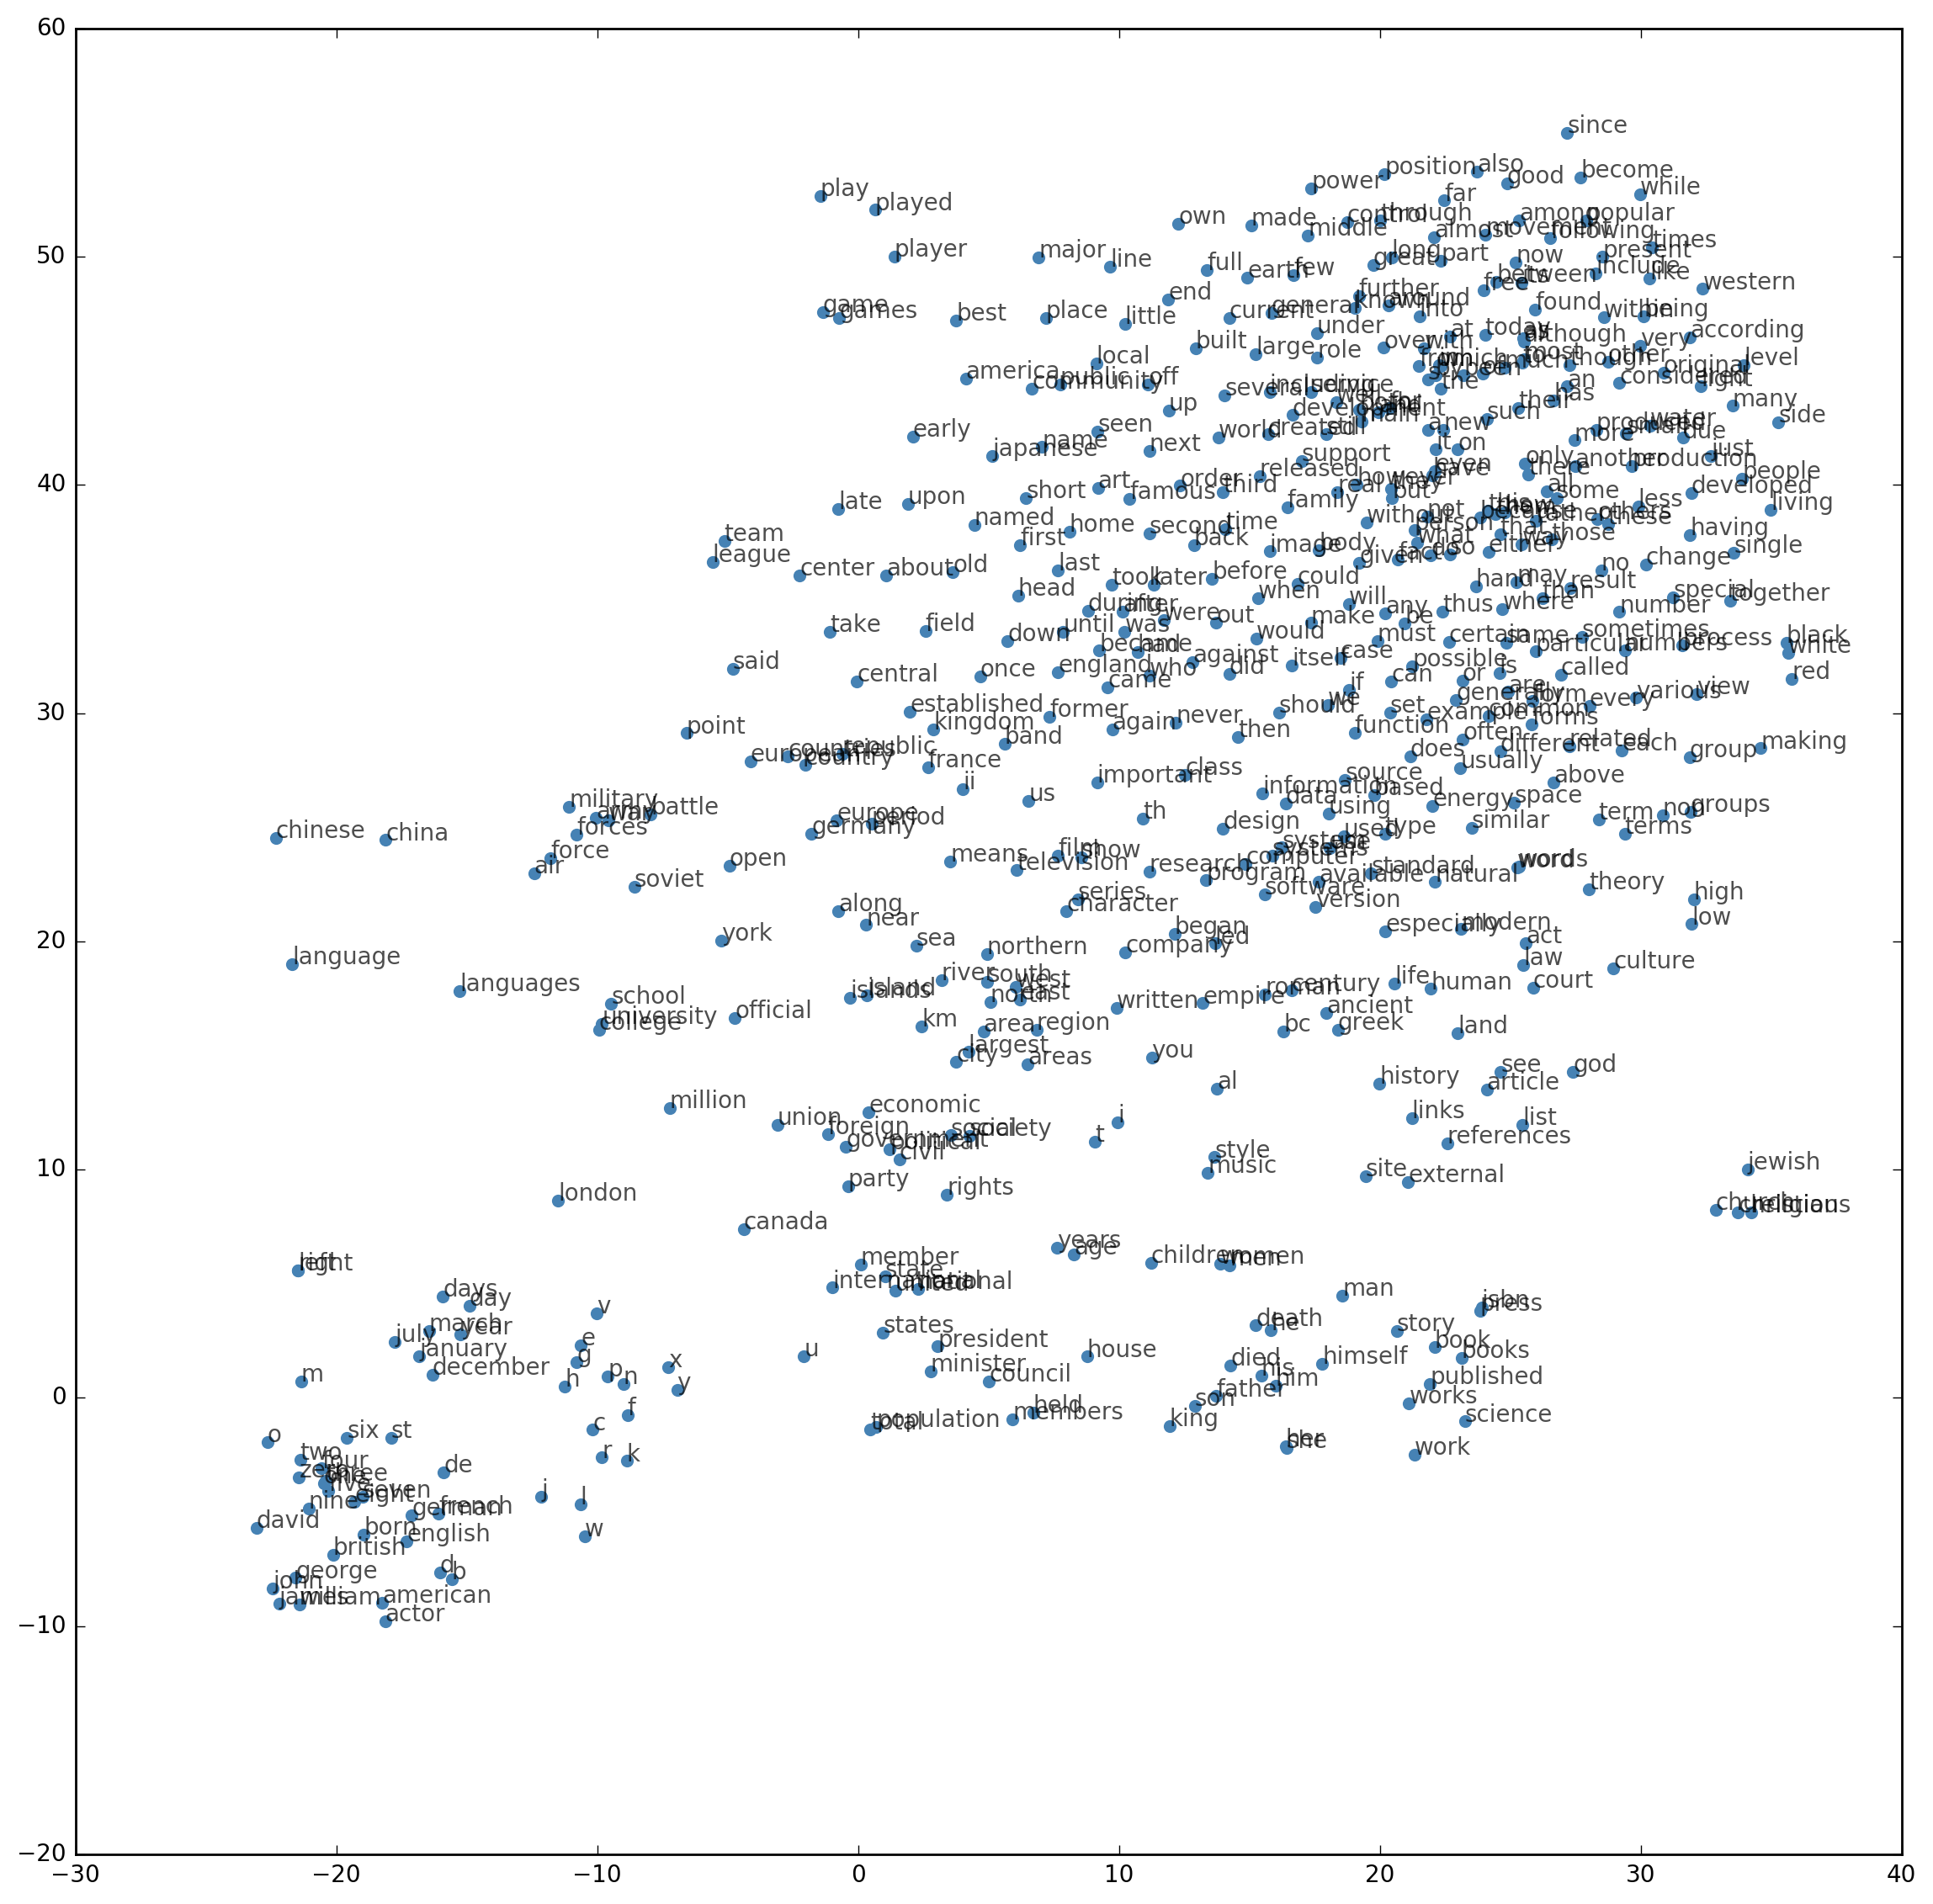